In [6]:
import casadi as ca
import numpy as np
from fabrics.diffGeometry.spec import Spec

Creating a simple spec that describes collision avoidance behavior. `x` here is the distance to the obstacle.

In [7]:
x = ca.SX.sym('x', 1)
xdot = ca.SX.sym('xdot', 1)
M = ca.SX([[1.0]])
f = ca.vcat([-3.0/x[0] * ca.norm_2(xdot)**2])
simple_spec = Spec(M, f=f, x=x, xdot=xdot)
simple_spec.concretize()


Now we need to create a differential map `phi` between robot configuration space and the distance. Let us first define an obstacle.

In [8]:
from mpscenes.obstacles.sphere_obstacle import SphereObstacle
circle_dict = {
    'type': 'SphereObstacle',
    'geometry': {
        'position': [1.0, 0.0],
        'radius': 0.5,
    }
}
obstacle = SphereObstacle(name="CircleObstacle", content_dict = circle_dict)

In [9]:
from fabrics.diffGeometry.diffMap import DifferentialMap
from fabrics.helpers.variables import Variables
q = ca.SX.sym('q', 2)
qdot = ca.SX.sym('qdot', 2)
variables = Variables(state_variables={'q': q, 'qdot': qdot})
phi = ca.norm_2(q - obstacle.position())/obstacle.radius() - 1
diff_map = DifferentialMap(phi, variables)

Now, the spec can be pulled using

In [10]:
pulled_spec = simple_spec.pull(diff_map)
pulled_spec.concretize()

Test the spec inside a planar simulation environment.
The spec produces a trajectory which will be visualized by the environment.

In [11]:
import gym
import numpy as np
import planarenvs.point_robot
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Run the simulation to create the trajectory

In [12]:
env = gym.make("point-robot-acc-v0", render=True, dt=0.01)
init_pos = np.array([-1.0, 0.1])
init_vel = np.array([1.3, 0.0])
ob = env.reset(pos=init_pos, vel=init_vel)
env.add_obstacle(obstacle)
n_steps = 1000
positions = np.zeros((n_steps, 2))
for i in range(n_steps):
    x = ob['joint_state']['position']
    positions[i] = x
    xdot = ob['joint_state']['velocity']
    M, h, action = pulled_spec.evaluate(q=x, qdot=xdot)
    ob, _, _, _ = env.step(action)
env.close()

Visualize the trajectory

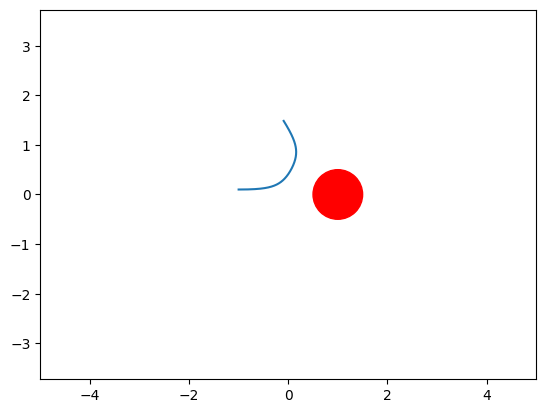

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
axs.plot(positions[:,0], positions[:,1])
axs.axis('equal')
axs.set_xlim(-5,5)
axs.set_ylim(-5,5)
obst1 = plt.Circle(obstacle.position(), radius=obstacle.radius(), color='r')
axs.add_patch(obst1)
plt.show()